## CS4487 Deepfake Detection - Final Report

#### Group 21: WANG Yian (56641105), SUN Yining(40141221)

### 1. Background

#### 1.1 Introduction

Deepfakes are synthetic media in which a person in an existing image or video is **replaced with someone else's likeness**. The main machine learning methods used to create deepfakes are based on deep learning and involve training generative neural network architectures, such as autoencoders, or generative adversarial networks (GANs).



DeepFake detection nowadays has become a pressing issue and a hot spot of
research. For example, one approach to deepfake detection is to use algorithms to recognize patterns and pick up subtle inconsistencies that arise in deepfake videos.

#### 1.2 Project Requirements

**Details about the project:**

Task: A binary classification problem

Input: RGB facial images of size 299 × 299 × 3

Output: A binary label to indicate whether an image is fake or not

Training set: 12,000 images, within which 8,000 images contain fake faces, and the rest images are real

Test set: 3,000 images that will not be released to the students

### 2. Research and Simple Attempts before Starting

#### 2.1 Xception

The Xception contains three parts, the entry flow, the middle flow, and the exit flow. 
* In the entry flow, it uses **residual connections**. 
* In the middle flow, it repeats this module eight times. 
* In the exit flow, the Xception uses global average pooling instead of fully connected layer and get 2048-dimensional vectors, which can reduce the spatial information.

In the exit flow, the logic line of the model splits into two lines. One  branch contains a 1* 1 convolution, which is used as residual connection.
Adding residual connections can improve the rate of convergence of the model.
Another contains three convolution modules. After doing this, the model adds the results of the two together. And then split into two lines again.

In the original **Depthwise Separable convolution layer**, first it does the depth-wise convolution, which uses each filter channel only at one input channel. To be more specific, it breaks the filter and image into three different channels and then convolve the corresponding image with corresponding channel and then stack them back. After that, it does the pointwise convolution, which uses a filter to cover the depth dimension. 

Differently, in the Xception, it first does the pointwise convolution using a 1*1 convolution to process the cross-chanel information, and then does the depth-wise convolution to obtain the spatial information and concatenate them. Parameters are reduced by this convolution to output same number of channels.

After researching, we decided to first try this original model to see the preformance. So we splited the dataset by train:val:test = 0.8:0.1:0.1 where label 0 represented fake faces and 1 represented real faces, and tested the model with different hyperparameters for several times, the best accuracy we recorded was about:

```
test accuracy: tensor([0.6587], device='cuda:0')
```

#### 2.2 VGG19

VGG19 is a convolution neural net(CNN) architecture which was used to win ILSVR competition in 2014. And it is considered to be one of the excellent vision model architecture.

**Architecture:**

* Fixed size of (224 * 224) RGB image was given as input to this network, which means that the matrix was of shape (224,224,3).

* The only preprocessing that was done is that they subtracted the mean RGB value from each pixel, computed over the whole training set.

* Used kernels of (3 * 3) size with a stride size of 1 pixel, this enabled them to cover the whole notion of the image.

* Spatial padding was used to preserve the spatial resolution of the image.
Max pooling was performed over a 2 * 2 pixel windows with sride 2.

* This was followed by Rectified linear unit(ReLu) to introduce non-linearity to make the model classify better and to improve computational time, as the previous models used tanh or sigmoid functions.

* Implemented three fully connected layers from which the first two were of size 4096 and after that, a layer with 1000 channels for 1000-way ILSVRC classification. And the final layer is a softmax function.

We also tried this model in a simple and naive way just as above, and got the following output:

```
test accuracy: tensor([0.7065], device='cuda:1')
```

#### 2.3 ResNet

The ResNet people are discussing today is basically from a paper published in 2015. Intuitively, we can reach a conclusion that deeper neural networks can achieve higher accuracy if they are appropriately trained; this is mainly because deeper networks have an opportunity to learn more features. However, it is not usually the case. In reality, we usually found that, with the network depth increasing, the accuracy gets saturated and then degrades rapidly, which may not be surprising. The authors then realized that this is not because of overfitting, and adding more layers will lead to high training error.

We don’t want results getting worse, so at least we hope that when the networks get deeper, it can keep the same accuracy as before in the worst case. To solve this problem, the researchers address **a deep residual learning framework**. In detail, instead of hoping each layer directly fits a desired underlying mapping, they explicitly let these layers fit a residual mapping. The researchers hypothesized that optimizing the residual mapping is easier than optimizing the original one. The team created a shortcut connection in the network, which greatly reduced the degradation without increasing the computational complexity and without adding new parameters.

We chose the resnet50 as it had a good performance in the experiement and paper while cost less than other larger network. We processed the data just as previous and add a simple convolution layer for adjusting the data shape, and got the result:

```
test accuracy: tensor([0.7839], device='cuda:1')
```

#### 2.4 Other Attemps and Decision

During researching, we also found some other people have tried to detect the fake faces by using simple SVM, naive bayes, etc., which all gave the test accuracy at around 60% to 65%. As a result, we determined our base line is **65% for test accuracy**.

Inspired by the paper of resnet, we were awared that it may not be a good idea to simply implement very deep networks to achieve good accuracy. Moreover, during testing the existed models, we found that it may take a long time to train, so due to the time limitation of the project, we should also mind the training speed of the model.

As the resnet was not so costy when training and gave a good performance in naive testing, we decided to stick to resnet to do the further research.

### 3. Data Preprocessing

To do the detection, our model should have two functions: first extract the features from the images and then do the binary classification according to the features. At the beginning, we wanted to see whether there are some diffenrences in terms of number between fake faces and real faces. 

In this section, we use the original folder sturcture:

```
|--- data
    |--- original
         |---0001.png
         |---...
    |--- manipulated
         |---...
```

To initialize Python. Run the below cell.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import PIL
import torchvision
from random import randrange

import os
from pathlib import Path
import math

#### 3.1 Image Histogram

First, we looked into the the image histogram. 
An image histogram is a type of histogram that acts as a graphical representation of **the tonal distribution in a digital image**. It plots the number of pixels for each tonal value. 
We find some reports that say the peak of the fake images’ histogram and the real images’ histogram varies. 
That is, in the image histogram of fake images, the peaks of the three primary colors (RGB) basically overlap, while in the image histogram of real images, the peaks of the three primary colors (RGB) do not overlap at all.
So we want to figure out whether this approach fits our data set well.

To get the file path of the images, please run the below cell.

In [2]:
def get_file_name(base):
    for path, dir, file in os.walk(base):
        for f in file:
            if ".png" in f:
                yield(os.path.join(path, f))

- **Fake images**

Load the images that are under the path './data/manipulated/', these images are all fake. Run the following cell to view the image histograms of five fake images as examples.

In [3]:
def get_img_histo(file_path):
    image = cv2.imread(file_path)
    channels = cv2.split(image)
    colors = ('b', 'g', 'r')

    plt.figure()                # new a figure
    plt.title("RGB Histogram")  # title of figure
    plt.xlabel("Bins")          # xlabel: lightness 0-255
    plt.ylabel("# of Pixels")   # ylabel: # of pixels of one lightness

    for (channels, color) in zip(channels, colors):
        hist = cv2.calcHist([channels], [0], None, [256], [0, 255])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
        plt.ylim([0, 5000])
    plt.show()

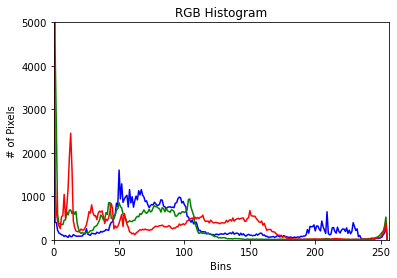

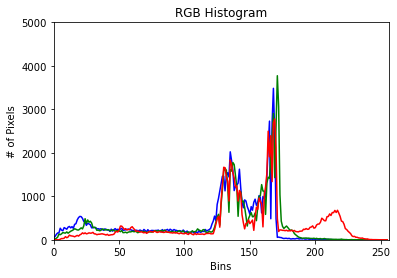

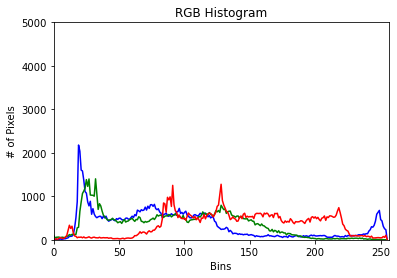

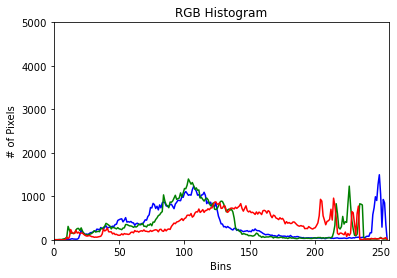

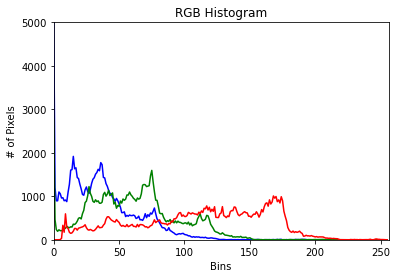

In [4]:
i = 0
for idx, file_path in enumerate(get_file_name('./data/manipulated/')):
    i += 1
    if i == 6: break
    
    get_img_histo(file_path)

- **Real images**

Load the images that are under the path './data/original/', these images are all real. Run the flolowing cell to view the image histograms of five real images as examples.

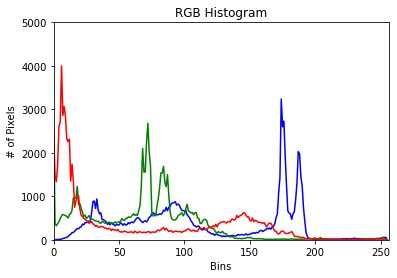

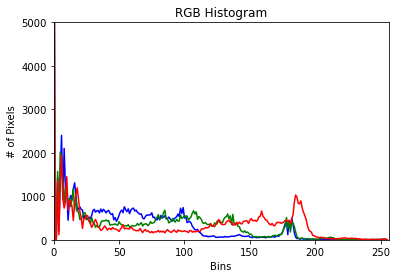

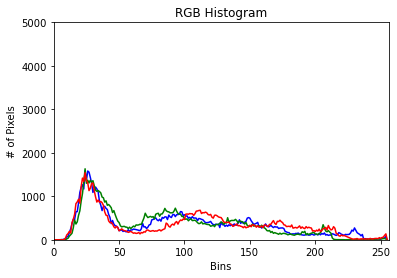

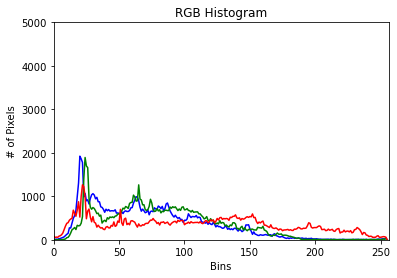

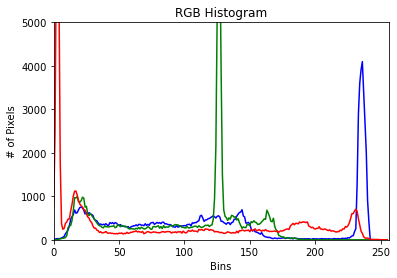

In [5]:
i = 0
for idx, file_path in enumerate(get_file_name('./data/original/')):
    i += 1
    if i == 6: break
        
    get_img_histo(file_path)

As we can see from the image histograms of our data set, some peaks of fake images’ histograms overlap, while others do not overlap at all. And there is no big diffenrences in terms of data patterns.

We did not get useful patterns in the above analysis, so we decided to not to use the method.

We also tested whether we should use HSV or RGB to record data, which turns out that RGB makes more sense for algorithms.

In the final model, we first normalize the data with mean and standard deviation, and then central crop them to smaller pictures as faces are all in the middle of the images:

```
torchvision.transforms.CenterCrop((255, 255))
torchvision.transforms.Normalize([0.5]*3, [0.5]*3)
```

### 4. Dataset Split and Data Augment

#### 4.1 Dataset Split

Becuase our batch size for training was 64 or 32, we decided to split the dataset in train:val:test = 0.8:0.1:0.1 = 9600:1200:1200.

Run the below cell to create directories.

In [10]:
base_path = "./input/"

Path(base_path + "train").mkdir(parents=True, exist_ok=True)
Path(base_path + "val").mkdir(parents=True, exist_ok=True)
Path(base_path + "test").mkdir(parents=True, exist_ok=True)

At the very beginning, we just splited the images randomly into three group. However, when we looked into the filenames of the images, we realized that there were different types of fake images which may be generated by different deepfake algorithms. As a result, we thought that we needed to keep the three datasets **balanced and representative after spliting**.

Run the below cell to get the fake face types and the distribution.

In [7]:
fake_type = []
for idx, file_path in enumerate(get_file_name('./data/manipulated/')):
    fake_type.append(((file_path.split('/'))[-1]).split('_')[0])
    
fake_type = np.array(fake_type)
print(np.unique(fake_type, return_counts=True))
fake_type = np.unique(fake_type).tolist()

(array(['DF', 'F2F', 'FS', 'NT', 'eyes', 'mouth'], dtype='<U5'), array([1333, 1335, 1333, 1333, 1333, 1333]))


Run the below cell to split the dataset.

In [11]:
image_data = {
    'real': [],
    'DF': [],
    'F2F': [],
    'FS': [],
    'NT': [],
    'eyes': [],
    'mouth': []
}

for idx, file_path in enumerate(get_file_name('./data/')):
    img = Image.open(file_path)
    
    if 'manipulated' in file_path: 
        for i, t in enumerate(fake_type):
            if t in file_path:
                image_data[t].append(img.filename)
                break
    else:
        image_data['real'].append(img.filename)
        
    img.close()

for k, v in image_data.items():
    print(k, len(v))

train = 0.8
val = 0.1
test = 0.1

train_path = "./input/train/"
val_path = "./input/val/"
test_path = "./input/test/"

for k, v in image_data.items():
    train_len = math.ceil(len(v)*train)
    val_len = math.floor(len(v)*val)
    test_len = len(v) - train_len - val_len
#     print(k, train_len, val_len, test_len)
    
    for idx, t in enumerate(v):
        t = Image.open(t)
        if idx < train_len:
            t.save(train_path + t.filename.split("/")[-1],"PNG")
        elif idx >= train_len and idx < (train_len+val_len):
            t.save(val_path + t.filename.split("/")[-1],"PNG")
        else:
            t.save(test_path + t.filename.split("/")[-1],"PNG")
        t.close()
for idx, file_path in enumerate(get_file_name('./input/train/')):
    if idx > 2: break
    img = Image.open(file_path)
    if idx == 0:
        img.save(test_path + img.filename.split("/")[-1],"PNG")
    if idx == 1 or idx == 2:
        img.save(val_path + img.filename.split("/")[-1],"PNG")
    img.close()
    os.remove(file_path)

    
print("train:val:test = {0}:{1}:{2}".format(len(os.listdir(train_path)), len(os.listdir(val_path)), len(os.listdir(test_path)) ))


real 4000
DF 1333
F2F 1335
FS 1333
NT 1333
eyes 1333
mouth 1333
train:val:test = 9600:1200:1200


#### 4.2 Data Augment

**Data augmentation** are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.

Data augmentation for image classification:

* Rotation
* Width & Height shift
* Rescale
* Horizontal & Vertical
* Flips
* ... ...

We randomly horizontal fliped or rotated by 10 to 20 degrees for every image once to augment the dataset.

In [12]:
train_path = "./input/train/"

number = 0
for idx, file_path in enumerate(get_file_name(train_path)):
    img = Image.open(file_path)
    rand = randrange(3)
    
    if rand == 0:
        img_m = torchvision.transforms.RandomRotation((10, 20))(img)
        img_m.save(img.filename[:-4]+"-rot.png", "PNG")
    elif rand == 1:
        img_m = torchvision.transforms.RandomHorizontalFlip()(img)
        img_m.save(img.filename[:-4]+"-hf.png", "PNG")
    elif rand == 2:
        img_m = torchvision.transforms.RandomHorizontalFlip()(img)
        img_m = torchvision.transforms.RandomRotation((10, 20))(img_m)
        img_m.save(img.filename[:-4]+"-hfrot.png", "PNG")


count = 0
for idx, file_path in enumerate(get_file_name(train_path)):
    if "-" in file_path.split("/")[-1]: count += 1
print("augment images:", 9600)

print("tarin set size:", 19200)

augment images: 9600
tarin set size: 19200


### 5. Training Details

Our model is inspired by the relatively good performance when resnet50 combining with serveral convolution layers. The images are certrally cropped before putting into the model becuase usually faces are in the certer of the images. After that all images are normalized with the mean and the standard deviation to make sure the model can converge better.

We tried different combinations of the layers and chose the relatively stable one, which will be discussed later in the report. Note that the pretrained resnet50 used in this case is trained on imagenet and is NOT relative to deepfake or deepfake detection.

In [13]:
class Model(nn.Module):
    def __init__(self, class_num: int = 2):
        super(Model, self).__init__()

        self.resnet = torchvision.models.resnet50()
        # self.resnet_pretrain = torchvision.models.resnet50(pretrained=True) # for testing

        self.conv1 = nn.Conv2d(3,32,3,2,0,bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,3,3,padding=2,bias=False)
        self.bn3 = nn.BatchNorm2d(3)
        self.maxpooling3 = nn.MaxPool2d(kernel_size=(2, 2), padding=1)

        self.avgpooling1 = nn.AvgPool2d(kernel_size=(2, 2))
        
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1000, 64)
        self.fc2 = nn.Linear(64, class_num)
        
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, input):

        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpooling3(x)
        
        x = self.resnet(x)
                
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
has_cuda = torch.cuda.is_available()
device = torch.device ("cuda:2") if has_cuda else torch.device("cpu")

# process data
GENERAL_TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((255, 255))
])

TRAIN_TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5]*3, [0.5]*3)
])
VAL_TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# fake - 0
# real - 1

# prepare the data
X_train = []
y_train = []
for idx, file_path in enumerate(get_file_name('./input/train/')):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    # img = torchvision.transforms.functional.adjust_contrast(img, 2) # if need enhance contrast

    img = GENERAL_TRANSFORM(img)
    img = TRAIN_TRANSFORM(img)
    X_train.append(img)
    
    if '_' in file_path.split("/")[-1]: 
        y_train.append(0)
    else:
        y_train.append(1)

y_train = np.asarray(y_train)
print("y_train", np.unique(y_train, return_counts=True))


X_val = []
y_val = []
for idx, file_path in enumerate(get_file_name('./input/val/')):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    
    # img = torchvision.transforms.functional.adjust_contrast(img, 2)

    img = GENERAL_TRANSFORM(img)
    img = VAL_TRANSFORM(img)
    X_val.append(img)
    
    if '_' in file_path.split("/")[-1]: 
        y_val.append(0)
    else:
        y_val.append(1)

y_val = np.asarray(y_val)
print("y_val", np.unique(y_val, return_counts=True))

X_train, y_train = torch.stack(X_train), torch.Tensor(y_train)
X_val, y_val = torch.stack(X_val), torch.Tensor(y_val)


**Note**: we found that a pytorch checkpoint could be saved here to save time for later training with the same data.
```python
# save
torch.save({
    "X_train": X_train,
    "X_val": X_val,
    "y_train": y_train,
    "y_val": y_val,
}, "checkpoints/name.pkl")

# load
checkpoint = torch.load("checkpoints/name.pkl")
X_train = checkpoint["X_train"]
X_val = checkpoint["X_val"]
y_train = checkpoint["y_train"]
y_val = checkpoint["y_val"]
```

In [ ]:
# initialize batchsize and dataloader
train_batchsize = 32
val_batchsize = 16

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = train_batchsize, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = val_batchsize, shuffle = True)


In [ ]:
echos = 35
learning_rate = 0.001
model = Model()
model_adam = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(model_adam, gamma=0.98)
loss_function = nn.CrossEntropyLoss()

model = model.to(device)


best_model_wts = model.state_dict()
best_acc = 0
# train
for i in range(echos):
    print(i)
    model.train()
    for batch_idx,(image, target) in enumerate(train_loader):

        image = image.to(device)
        target = target.to(device)

        model_adam.zero_grad()
        output = model(image)
        _, preds = torch.max(output.data, 1)
        loss = loss_function(output, target.long())
        
        if batch_idx == 1:
            print("train_loss:", loss)
            print("train_accuracy:", torch.sum(preds == target).data/train_batchsize)
        
        loss.backward()
        model_adam.step()


    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx,(image, target) in enumerate(val_loader):
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            _, preds = torch.max(output.data, 1)
            loss = loss_function(output, target.long())
            correct += torch.sum(preds == target).to(torch.float32)
            if batch_idx == 1:
                print(correct)
                print("val_loss:", loss)

        current_acc = correct / len(val_dataset)
        print("val_accuracy:", current_acc)

        if current_acc > best_acc:
            best_acc = current_acc
            best_model_wts = model.state_dict()
    scheduler.step()
    if loss > 1: break

torch.save(model.state_dict(), "output/best_" + str(echos) + ".pkl")


### 6. Test Code

In [ ]:
model = Model()
best_model_wts = torch.load("name.pkl")
best_acc = 0

# test
def test_model(model, best_model_wts, test_img_path):
    has_cuda = torch.cuda.is_available()
    device = torch.device ("cuda:2") if has_cuda else torch.device("cpu")
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    def get_file_name(base):
        for path, dir, file in os.walk(base):
            for f in file:
                if ".png" in f:
                    yield(os.path.join(path, f))
    TEST_TRANSFORM = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop((255, 255)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    test_batchsize = 1
    X_test = []
    y_test = []

    for idx, file_path in enumerate(get_file_name(test_img_path)):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # img = torchvision.transforms.functional.adjust_contrast(img, 2)
        
        img = TEST_TRANSFORM(img)
        X_test.append(img)
        
        if '_' in file_path.split("/")[-1]: 
            y_test.append(0)
        else:
            y_test.append(1)

    y_test = np.asarray(y_test)
    print("y_test", np.unique(y_test, return_counts=True))


    X_test, y_test = torch.stack(X_test), torch.Tensor(y_test)

    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = test_batchsize, shuffle = True)


    correct = 0
    with torch.no_grad():
        model.load_state_dict(best_model_wts)
        model.eval()
        for batch_idx,(image, target) in enumerate(test_loader):

            image = image.to(device)
            target = target.to(device)

            output = model(image)
            _, preds = torch.max(output.data, 1)
            loss = loss_function(output, target.long())
            
            correct += (preds == target)
            print(correct)
            print("loss:", loss)

        print("test accuracy:", correct / test_loader.__len__())

test_model(model, best_model_wts, './input/test/')


### 7. Experiment

To design the network structure, we first tried the design people used in *MesoNet*. Just as mentioned before, we wanted to make our network small and fast to train, so MesoNet was choosen because it was a simple network with a theoretically good accuracy.

The network structure was basically like:
1. 2 convolution layers with the identical sturcutre: conv -> batch normalization -> max pooling (channel: 3->8->3).
2. resnet 34 or 50.
3. MLP.

And We tried following parameters in the experiment:
1. test batch size: 32 or 64
2. epoch: 15, 25, 35, 45
3. optimizer: adam, nadam
4. image size adjustment: resize or crop
5. scheduler: ExpLR, StepLR
6. learning rate initialization: 0.005, 0.001
7. resnet type: resnet18, resent34, resnet50

The result were:
1. did not give much difference in our case.
2. test accuracy increasing from 15 to 35, but decrease a little bit when 45, which indicates an overfitting problem.
3. did not give much difference in our case.
4. resize is a better choice for this model (multiple attempts conducted, result in around 0.82(resize) > 0.79(crop)).
5. model converged fast when using ExpLR, this may becuase the exponential curve feats the situation better, but the test accuracies were similar.
6. lr = 0.001 gave a better performance.
7. resnet50 gave higher test accuracy, may be because it is a carefully-designed deeper netwrok.

Due to the time limitation, we did not tase all combination of the 6 aspects; however, we kept the other parameters identical when testing one of them.

We adjusted the parameters after the experiment. The best test accuracy was around 81% to 82% with:

1. test batch size: 32
2. epoch: 30
3. optimizer: adam
4. image size adjustment: resize
5. scheduler: ExpLR
6. learning rate initialization: 0.001
7. resnet type: resnet50

Then we changed the model structure to see if there was an improvement:
1. add one more convolution layer.
2. change the first pooling layer from maxpooling to avepooling.
3. change channel number: 3->16->3, 3->16->32->3

However, we did not get better result, the test accuracy were all around 76%-79%.

Then we were inspired by the original Xception model, and tried to design our convolution layers as it did before (of course, we have some adjustments), which improved the model performance a little.

The following parameters were tested during the experiment:
1. epoch: 25, 30, 35, 45
2. image size adjustment: no adjustment, resize, crop
3. resnet type: resnet34 or resnet50
4. if the resnet was pretrained on imagenet (not related with deepfake)
5. if the contrast of images were enhanced
6. channel number minor adjustment

The result were:
1. epoch 35 was a good stop point for pretrained one, and 45 was good for the original one.
2. cropped images gave the better performance in this case.
3. resnet50 converged faster and the accuracy was a little better than resnet34, but resnet34 was not bad and easier to train.
4. pretrained one converged faster, but the one without pretraining could achieve the similar accuracy with more epoches.
5. did not gave much differences.
6. after multiple adjustments, we decided the current model.

### 8. Result and Reflection

The accuracy of our model is around:
```
val_loss: tensor(0.0017, device='cuda:2')
val accuracy: tensor([0.8592], device='cuda:0')
test accuracy: tensor([0.8525], device='cuda:0')
```
which is not good, while the train accuracy reach 98% to nearly 100% at the final stage. This is an obvious symbol of overfitting. However, according to the data from above experiment, we can also tell that this is not because we over-trained the model. As a result, this is probably caused by the improper data augment, which cause there were too much similar pictures in the training set. May be we should implement a more reasonable augmentation logic or model structure to prevent this problem when encounting a relatively small training set. This benefits us that though model structure and idea are very important, we should also mind the data we used during researching carefully. We were aware of this point before starting the project, but did not pay enough attention on it, which eventually leads to a problem.

Moreover, we should also gather more information during training to analyse why the model gives such result, in which case it gives the correct answer, in which case not. However we did not complete the experiments due to the lack of time.

Actually, we also tried to classify the images in a multi-class approach once we noticed the well-structured file names, which did not gave an impressive result at that time, and we did not stick to that. But this approach was proved by our classmates that could give good performance. We were taught that we should give a more comprehensive attempt before changing the direction.

Overall, though the final result is not that satisfying, but we have learned a lot in doing this project and got some experience in terms of computer vision.